# Exploratory data analysis on Season 2 results

I'm curious about the players' music preferences and how they might be clustered. Also of interest is how strategy can be optimized amongst these players. For example, if I liked song $k$ on week $n$, was it likely to have been submitted by Player $X$? (Furthermore, should I sabatoge my scoring preferences if I believe that Player $X$ is currently winning the game?)

I'm also just interested in how to analyze data that are (a) sparse, (b) human-biased, and (c) come in the abhorrent format of spreadsheets with tabs. Just kidding about that last one (although it would benefit me to learn some proper Excel file I/O).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
% matplotlib inline

print('Note that I am using Pandas version {}'.format(pd.__version__))

Note that I am using Pandas version 0.22.0


In [2]:
# directory info
root_dir = os.path.join(os.getcwd(), '..')
data_dir = os.path.join(root_dir, 'data')
results_dir = os.path.join(root_dir, 'results')

In [116]:
# constants and file organization
num_weeks = 10
num_players = 8 

fname = os.path.join(data_dir, 'season2.xlsx')


In [5]:
df = pd.read_excel(fname, sheet_name=0)
df

,song name,submitter,gold,silver,bronze,total,total w/ bonus,recognize count,vote gold,vote silver,vote bronze,rec
1.0,saigo no bansan - radwimps,stvntol,3.0,1.0,NaN,11,14.0,NaN,2.0,4.0,8.0,NaN
2.0,frederic - oddloop,watchwolf92,1.0,1.0,1.0,6,9.0,NaN,1.0,6.0,3.0,NaN
3.0,taeyeon - 11:11,pseudo,1.0,NaN,1.0,4,7.0,NaN,1.0,8.0,5.0,NaN
4.0,Summer Solstice - Moonlit Sailor,chris,NaN,2.0,2.0,6,9.0,NaN,1.0,8.0,2.0,8.0
5.0,Phoria-Melatonin,nikita,NaN,NaN,1.0,1,4.0,NaN,6.0,4.0,8.0,NaN
6.0,Lifting The Seas-Hunt,jwuphysics,2.0,1.0,NaN,8,11.0,NaN,8.0,7.0,4.0,NaN
7.0,A Fine Frenzy,citrus,NaN,1.0,NaN,2,5.0,NaN,3.0,1.0,8.0,NaN
8.0,Emancipator,gracebunella,1.0,2.0,3.0,10,10.0,1.0,6.0,2.0,4.0,NaN
NaN,NaN,NaN,8.0,8.0,8.0,48,NaN,NaN,NaN,NaN,NaN,NaN


## Data cleaning

Let's remove the bottom row, which seems to only be a line for error-checking. Recognized songs technically came with a penalty, but I won't consider that here. ~~We'll also remove the player `nikita`, who dropped out after week 1.~~ Since every week there was an extra player, whether it be `nikita`, who did not finish, or a guest, I'll have to remove that data.

In [102]:
# get relevant columns
names = ['player', 'votegold', 'votesilver', 'votebronze']
col_nums = [2, 9, 10, 11]

df = pd.read_excel(fname, sheet_name=0, names=names, usecols=col_nums)
df.set_index('player', inplace=True)
df

,votegold,votesilver,votebronze
player,,,
stvntol,2.0,4.0,8.0
watchwolf92,1.0,6.0,3.0
pseudo,1.0,8.0,5.0
chris,1.0,8.0,2.0
nikita,6.0,4.0,8.0
jwuphysics,8.0,7.0,4.0
citrus,3.0,1.0,8.0
gracebunella,6.0,2.0,4.0
NaN,NaN,NaN,NaN


In [103]:
# remove rows with NaN and nikita
#df.drop('nikita', axis='index', inplace=True)
df.dropna(axis='index', inplace=True)
df

,votegold,votesilver,votebronze
player,,,
stvntol,2.0,4.0,8.0
watchwolf92,1.0,6.0,3.0
pseudo,1.0,8.0,5.0
chris,1.0,8.0,2.0
nikita,6.0,4.0,8.0
jwuphysics,8.0,7.0,4.0
citrus,3.0,1.0,8.0
gracebunella,6.0,2.0,4.0


In [104]:
# force int-casting of vote columns
df = df.astype(dict(votegold=np.int8, votesilver=np.int8, votebronze=np.int8))
df

,votegold,votesilver,votebronze
player,,,
stvntol,2,4,8
watchwolf92,1,6,3
pseudo,1,8,5
chris,1,8,2
nikita,6,4,8
jwuphysics,8,7,4
citrus,3,1,8
gracebunella,6,2,4


In [158]:
# treat nikita as guest
players = df.index.tolist()
idx = players.index('nikita')
players[idx] = 'guest'

df.index = players

In [160]:
# enumerate the players (note 0-index)
players = df.index.values
player_ids = dict(zip(players, np.arange(num_players + 1)))

for player, i in player_ids.items():
    print('{} {}'.format(i, player))
    

0 stvntol
1 watchwolf92
2 pseudo
3 chris
4 guest
5 jwuphysics
6 citrus
7 gracebunella


In [161]:
# now make vectors for each player's vote
vote_matrix = np.zeros((num_players, num_players))

# cast votes
for player, [votegold, votesilver, votebronze] in df.iterrows():
    try:
        player_id = player_ids[player]
    except KeyError:
        player_id = 4 # guest

    vote_matrix[player_id, votegold-1] += 3
    vote_matrix[player_id, votesilver-1] += 2
    vote_matrix[player_id, votebronze-1] += 1

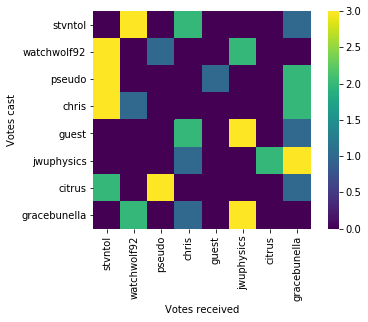

In [162]:
sns.heatmap(vote_matrix, xticklabels=players, yticklabels=players, square=True, cmap='viridis')
plt.xlabel('Votes received')
plt.ylabel('Votes cast');

### See all votes

**TODO: correct function so that we map new player IDs onto old player IDs**

In [258]:
# convenience function
def organize_votes(df):
    """Takes in a Pandas dataframe indexed by player names. Columns should be 
    IDs of the players for whom the indexed player voted. Returns a vote matrix
    similar to the one seen above.
    """
    
    df.set_index('player', inplace=True)
    
    # clean data
    df.dropna(axis='index', inplace=True)
    df = df.astype(dict(votegold=np.int8, votesilver=np.int8, votebronze=np.int8))
    
    # determine new player IDs
    new_player_ids = dict(zip(df.index.values, np.arange(num_players + 1)))

    # record votes (note that the guest ID is always 4)
    vote_matrix = np.zeros((num_players, num_players))
        
    for player, [votegold, votesilver, votebronze] in df.iterrows():
        try:
            player_id = new_player_ids[player]
        except KeyError:
            player_id = 4
        
        vote_matrix[player_id, votegold-1] += 3
        vote_matrix[player_id, votesilver-1] += 2
        vote_matrix[player_id, votebronze-1] += 1
    
    return vote_matrix

In [259]:
# in case these got overwritten somehow
fname = os.path.join(data_dir, 'season2.xlsx')
names = ['player', 'votegold', 'votesilver', 'votebronze']
col_nums = [2, 9, 10, 11]

# store results in a 3d array
vote_array = np.zeros((num_weeks, num_players, num_players))

for k in range(num_weeks):
    df = pd.read_excel(fname, sheet_name=k, names=names, usecols=col_nums)

    vote_array[k] = organize_votes(df)

Week 1
   stvntol 0
   watchwolf92 1
   pseudo 2
   chris 3
   nikita 4
   jwuphysics 5
   citrus 6
   gracebunella 7
Week 2
   pseudo 0
   gracebunella 1
   stvntol 2
   jwuphysics 3
   watchwolf92 4
   chris 5
   citrus 6
Week 3
   jwuphysics 0
   stvntol 1
   citrus 2
   psuedo 3
   chris 4
   gracebunella 5
   watchwolf92 6
Week 4
   gracebunella 0
   citrus 1
   c h r i s 2
   jwuphysics 3
   stvntol 4
   watchwolf92 5
   pseudo 6
Week 5
   citrus 0
   jwuphysics 1
   gracebunella 2
   pseudo 3
   stvntol 4
   watchwolf92 5
   c h r i s 6
Week 6
   jwuphysics 0
   watchwolf92 1
   psuedo 2
   stvntol 3
   gracebunella 4
   chris 5
   citrus 6
Week 7
   gracebunella 0
   pseudo 1
   citrus 2
   chris 3
   jwuphysics 4
   jonathan 5
   stvntol 6
Week 8
   tony(chris's slot) 0
   jwuphysics 1
   pseudo 2
   citrus 3
   watchwolf92 4
   gracebunella 5
   stvntol 6
Week 9
   citrus 0
   pseudo 1
   gracebunella 2
   watchwolf92 3
   chris 4
   stvntol 5
   jwuphysics 6
Week 10
   stvnt

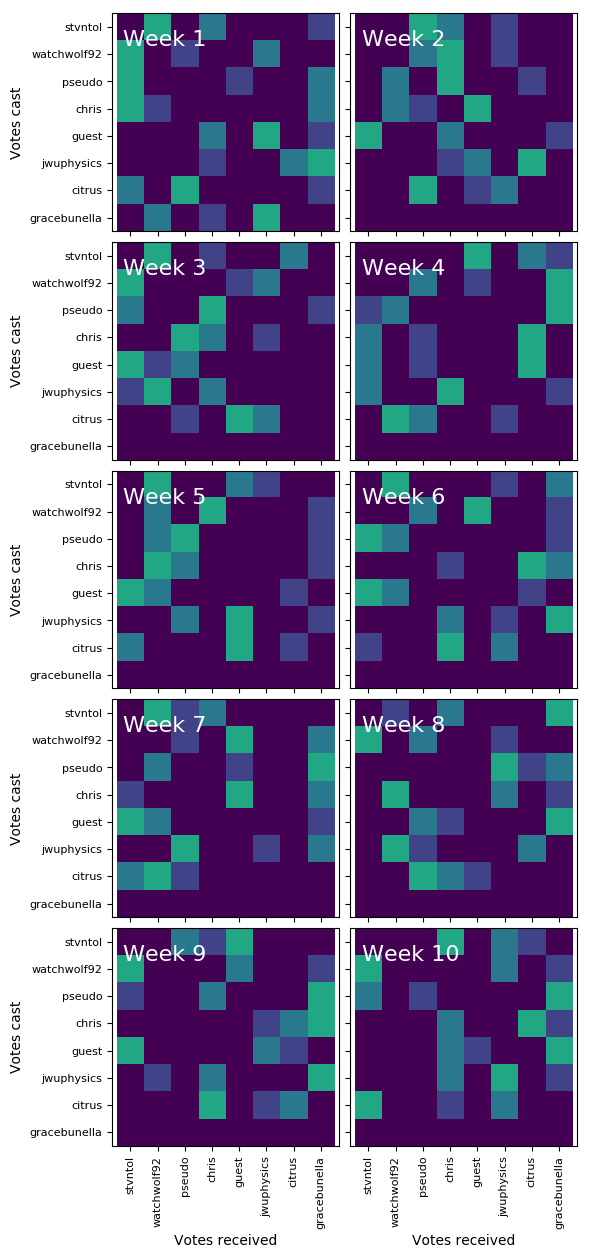

In [253]:
num_rows = 5
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, sharex=True, sharey=True, figsize=(3*num_cols, 3*num_rows), dpi=100)

for k, [vote_matrix, ax] in enumerate(zip(vote_array, axes.flat)):
    ax.imshow(vote_matrix, cmap='viridis', vmax=5)
    
    if k % num_cols == 0:
        ax.set_ylabel('Votes cast')
        ax.set_yticks(range(num_players))
        ax.set_yticklabels(players, fontsize=8)
    if k // num_cols == num_rows - 1:
        ax.set_xlabel('Votes received')
        ax.set_xticks(range(num_players))
        ax.set_xticklabels(players, rotation=90, fontsize=8)
    
    # label
    ax.text(0.05, 0.85, 'Week {}'.format(k+1), fontsize=16, color='white', transform=ax.transAxes)
    
fig.subplots_adjust(hspace=0.05, wspace=0.05)

Text(83.4,0.5,'Votes cast')

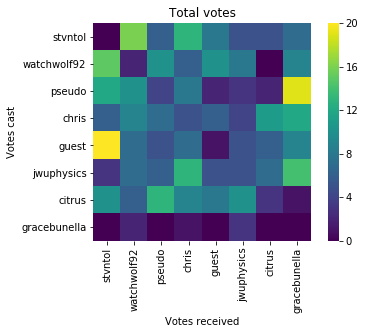

In [250]:
# total score
sns.heatmap(np.sum(vote_array, axis=0), xticklabels=players, yticklabels=players, square=True, cmap='viridis')
plt.title('Total votes')
plt.xlabel('Votes received')
plt.ylabel('Votes cast')
